<a href="https://colab.research.google.com/github/dannner66/data_science_NLP_beadando/blob/main/NLPprojektreDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Politikai hírek szentimentelemzése  
**Origo vs. Telex**  
_A projekt célja:_  
- Politikai hírek osztályozása
- Megvizsgálni, hogyan változik a politikai hírek hangvétele (baloldali, jobboldali, semleges)  
- Időbeli és aspektus‐alapú trendek feltárása  

---

## Tartalomjegyzék  
1. [Telepítés és importok](#1-telepítés-és-importok)  
2. [Bevezető és adatok bemutatása](#2-bevezető-és-adatok-bemutatása)  
3. [Előfeldolgozás](#3-előfeldolgozás)  
4. [Feature‐engineeering](#4-feature-engineering)  
5. [Modellek](#5-modellek)  
6. [Diagnosztika](#6-diagnosztika)  
7. [Aspektus‐ és időbeli elemzések](#7-aspektus-–-időbeli-elemzések)  
8. [Következtetések](#8-következtetések)  


# 1. Telepítés-és-importok

In [1]:
!pip install datasets
!pip install keybert
!pip install newspaper3k
!pip install lxml_html_clean
!pip install nltk
!pip install sentence-transformers
!pip install stanza
!pip install transformers
!pip install transformers torch
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [2]:
# Standard library
import datetime
import os
import random
import re
import requests
import time
from google.colab import userdata # API kulcsok elrejtésére és használására

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import (
    precision_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Deep Learning / Transformers
import torch
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)



# NLP & Text processing
import nltk
import stanza
from scipy.special import softmax
from scipy.stats import ttest_ind
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from keybert import KeyBERT
from newspaper import Article

# Web scraping
from bs4 import BeautifulSoup

# Utilities / Others
from datasets import Dataset, DatasetDict
from google.colab import files
from tqdm import tqdm
import joblib #mentés későbbi betöltéshez

# Általános beállítások
pd.options.display.max_columns = None
plt.rcParams['figure.figsize'] = (10,5)




# 2. Bevezető és adatok bemutatása

Ebben a szekcióban áttekintjük:
- **Adatforrások**: Origo (politikai és semleges cikkek), Telex (független hírek)  
- **Cikkek száma** és **forrásonkénti eloszlás**  
- **Időintervallum** (legkorábbi és legújabb dátum)  
- Egy **minta** (head) a `combined_df`-ből


In [3]:
!gdown 1Eg3LlLdznMeuqW6Scy4sfl-ueGn0D-op
!gdown 1SFAvhspMrCG71Gf03xLISla_7PD97VjF
!unzip -o /content/Adathalmaz.zip
!unzip -o /content/models.zip

Downloading...
From: https://drive.google.com/uc?id=1Eg3LlLdznMeuqW6Scy4sfl-ueGn0D-op
To: /content/Adathalmaz.zip
100% 5.70M/5.70M [00:00<00:00, 156MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1SFAvhspMrCG71Gf03xLISla_7PD97VjF
From (redirected): https://drive.google.com/uc?id=1SFAvhspMrCG71Gf03xLISla_7PD97VjF&confirm=t&uuid=b1ff73a7-49bd-45fb-a0cc-d223e494920e
To: /content/models.zip
100% 2.09G/2.09G [00:30<00:00, 68.8MB/s]
Archive:  /content/Adathalmaz.zip
   creating: Adathalmaz/
  inflating: Adathalmaz/allnews.csv  
  inflating: Adathalmaz/combined.csv  
  inflating: Adathalmaz/neutral_news.csv  
  inflating: Adathalmaz/origo_news.csv  
  inflating: Adathalmaz/telex_news.csv  
Archive:  /content/models.zip
   creating: models/
  inflating: models/article_sentiments_all.joblib  
  inflating: models/clean_text_series.joblib  
  inflating: models/lemmatized_series.joblib  
  inflating: models/logreg_pipeline.joblib  
  inflating: models/month_article_sentiments_

In [4]:
# 2.1 Adatok betöltése
neutral = pd.read_csv('Adathalmaz/neutral_news.csv')
telex = pd.read_csv('Adathalmaz/telex_news.csv')
origo = pd.read_csv('Adathalmaz/origo_news.csv')
df = pd.read_csv('Adathalmaz/allnews.csv')
combined_df = pd.read_csv('Adathalmaz/combined.csv')

In [5]:
# 2.2 Forrásonkénti eloszlás
print("Cikkek forrásonként:")
print(combined_df['label'].value_counts(), "\n")

# 2.3 Időintervallum – dátumkonverzió és üres értékek kiszűrése
combined_df['date'] = pd.to_datetime(combined_df['date'], errors='coerce')
# Ha szeretnéd látni, mennyi sor lett NaT:
# print(f"Hiányzó/érvénytelen dátumok: {combined_df['date'].isna().sum()}")

# Csak az érvényes dátumokat nézzük
valid_dates = combined_df['date'].dropna()
min_d, max_d = valid_dates.min().date(), valid_dates.max().date()
print(f"Időintervallum: {min_d} – {max_d}")

Cikkek forrásonként:
label
neutral    934
telex      691
origo      679
Name: count, dtype: int64 

Időintervallum: 2025-03-19 – 2025-04-19


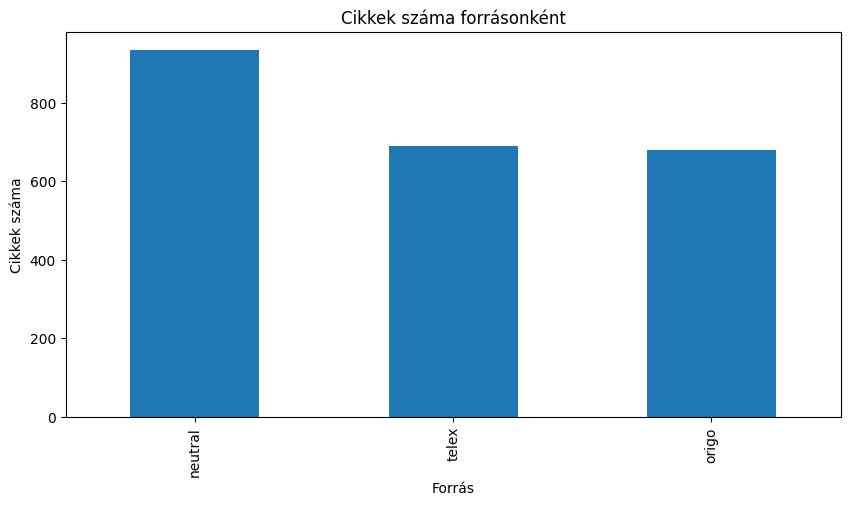

In [6]:
# 2.5 Grafikon: források aránya
combined_df['label'].value_counts().plot(kind='bar')
plt.title("Cikkek száma forrásonként")
plt.xlabel("Forrás")
plt.ylabel("Cikkek száma")
plt.show()

# 3. Előfeldolgozás

Ebben a szekcióban:
1. **Szövegtisztítás** (kisbetűsítés, linkek/írásjelek eltávolítása)
2. **Lemmatizálás** (morfológiai normalizálás Stanza-val)
3. **Stop-word eltávolítás** (opcionális, NLTK magyar stop-listával)


In [7]:
#alapvető tisztítás
combined_df.drop_duplicates(subset='text', inplace=True)
combined_df.dropna(subset=['text', 'label'], inplace=True)
combined_df = combined_df[combined_df['text'].str.len() > 100]

In [8]:
def clean_text(text):
    text = text.lower()  # kisbetűsítés
    text = re.sub(r'http\S+|www.\S+', '', text)  # linkek eltávolítása
    text = re.sub(r'\W', ' ', text)  # nem betű karakterek eltávolítása
    text = re.sub(r'\s+', ' ', text)  # felesleges szóközök törlése
    return text.strip()

#combined_df['clean_text'] = combined_df['text'].apply(clean_text)
os.makedirs('models', exist_ok=True)
#joblib.dump(combined_df['clean_text'], 'models/clean_text_series.joblib')
clean_series = joblib.load('models/clean_text_series.joblib')
combined_df['clean_text'] = clean_series

In [9]:
# Stanza lemmatizálás
stanza.download('hu')
nlp = stanza.Pipeline(lang='hu', processors='tokenize,pos,lemma', use_gpu=False, verbose=False)

#def lemmatize_text(text: str) -> str:
#    doc = nlp(text)
#    return " ".join(w.lemma for s in doc.sentences for w in s.words)

#combined_df['lemmatized'] = combined_df['clean_text'].apply(lemmatize_text)

# Mentsd el a kész Series-t
#joblib.dump(combined_df['lemmatized'], 'models/lemmatized_series.joblib')

combined_df['lemmatized'] = joblib.load('models/lemmatized_series.joblib')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: hu (Hungarian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/hu/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [10]:
# 3.3 Stop-word szűrés

nltk.download('stopwords')

stop_words = set(stopwords.words('hungarian'))

def remove_stopwords(text: str) -> str:
    tokens = text.split()
    filtered = [t for t in tokens if t not in stop_words]
    return " ".join(filtered)

combined_df['lemmatized_nostop'] = combined_df['lemmatized'].apply(remove_stopwords)

# Ellenőrzés
combined_df.head(3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,link,text,date,label,clean_text,lemmatized,lemmatized_nostop
0,Nincs cím,https://origo.hu/sport/rovat/sport-csapat,Újabb magyar csapat csatlakozik az osztrák köz...,NaT,neutral,újabb magyar csapat csatlakozik az osztrák köz...,új magyar csapat csatlakozik az osztrák közpon...,magyar csapat csatlakozik osztrák központú nem...
1,Nincs cím,https://origo.hu/sport/rovat/sport-egyeni,Hatodik olimpiájára készül a legendás magyar s...,NaT,neutral,hatodik olimpiájára készül a legendás magyar s...,hatodik olimpia készül a legendás magyar sport...,hatodik olimpia készül legendás magyar sportol...
2,Nincs cím,https://origo.hu/sport/rovat/sport-futball,Felháborító dolgokat írnak Szoboszlairól a Liv...,NaT,neutral,felháborító dolgokat írnak szoboszlairól a liv...,felháborító dolg ír szoboszlai a liverp győzel...,felháborító dolg ír szoboszlai liverp győzelem...


# 4. Feature‐engineering

Ebben a szekcióban:
1. Címkézés
2. **TF–IDF vektorizálás** a lemmatizált, stop-wordoktól tisztított szöveg oszlopból  
3. **Sentence-Transformer embeddingek** elkészítése  
4. Az előállított feature-mátrixok elmentése későbbi modell használathoz  


In [11]:
le = LabelEncoder()
combined_df['label_encoded'] = le.fit_transform(combined_df['label'])

# Ha megnéznéd:
print(dict(zip(le.classes_, le.transform(le.classes_))))
# kimenet: {'baloldali': 0, 'jobboldali': 1, 'semleges': 2}


{'neutral': np.int64(0), 'origo': np.int64(1), 'telex': np.int64(2)}


In [12]:
# models/ könyvtár létrehozása
#os.makedirs('models', exist_ok=True)

#vectorizer = TfidfVectorizer(
#    max_features=10000,
#    ngram_range=(1,2),
#    min_df=5,
#    max_df=0.8
#)

#X_tfidf = vectorizer.fit_transform(combined_df['lemmatized_nostop'])


# Mentés későbbi betöltéshez
#joblib.dump(vectorizer, 'models/tfidf_vectorizer.joblib')
#joblib.dump(X_tfidf,    'models/X_tfidf.joblib')



#print("TF–IDF kész, shape:", X_tfidf.shape)


#embed_model = SentenceTransformer('distiluse-base-multilingual-cased')
#embeddings = embed_model.encode(
#    combined_df['clean_text'].tolist(),
#    show_progress_bar=True,
#    batch_size=32
#)

# Mentés
#joblib.dump(embeddings, 'models/sbert_embeddings.joblib')


# TF–IDF mátrix betöltése
X_tfidf    = joblib.load('models/X_tfidf.joblib')
# Vectorizer visszaolvasása
vectorizer = joblib.load('models/tfidf_vectorizer.joblib')
# Embedding tömb betöltése
embeddings = joblib.load('models/sbert_embeddings.joblib')

print("SBERT embeddingek elkészültek, shape:", embeddings.shape)

SBERT embeddingek elkészültek, shape: (2126, 512)


# 5. Modellezés és diagnosztika

Ebben a szekcióban:
1. **Train/Test split**  
2. **Baseline modell**: MultinomialNB a TF–IDF alapján  
3. **Értékelés**: classification report és konfúziós mátrix  
4. **Logisztikus regresszió** összehasonlítás  
5. **SBERT+LR** és/vagy XLM-RoBERTa pipeline-inferencia
6. Összegzés


In [13]:
# Célváltozó: label_encoded (0=baloldali,1=jobboldali,2=semleges)
X = X_tfidf
y = combined_df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



MultinomialNB eredmények:
              precision    recall  f1-score   support

     neutral       0.98      0.96      0.97       156
       origo       0.84      0.64      0.72       132
       telex       0.72      0.90      0.80       138

    accuracy                           0.84       426
   macro avg       0.85      0.83      0.83       426
weighted avg       0.85      0.84      0.84       426



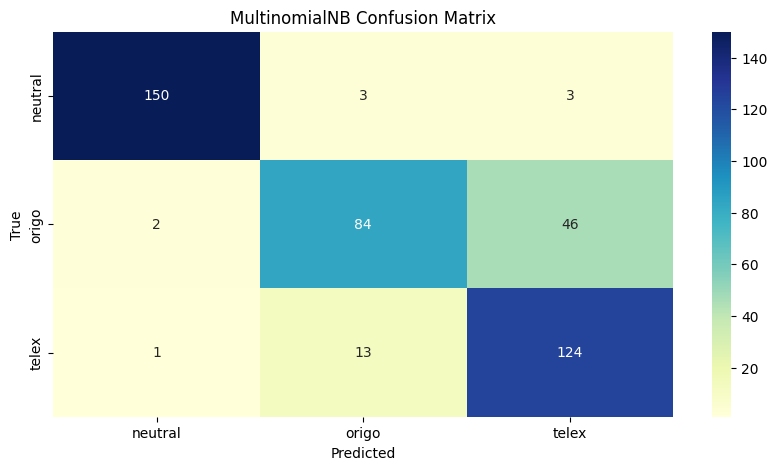

In [14]:
# 5.2 Baseline: MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("MultinomialNB eredmények:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

# Konfúziós mátrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap="YlGnBu")
plt.title("MultinomialNB Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

LogisticRegression eredmények:
              precision    recall  f1-score   support

     neutral       0.98      0.96      0.97       156
       origo       0.86      0.84      0.85       132
       telex       0.85      0.89      0.87       138

    accuracy                           0.90       426
   macro avg       0.90      0.90      0.90       426
weighted avg       0.90      0.90      0.90       426



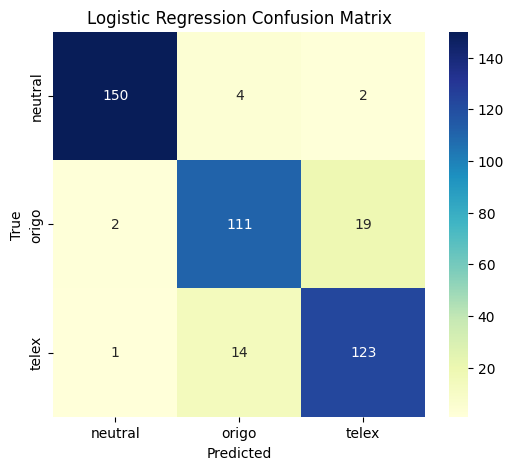

In [15]:
# 5.3 Logisztikus regresszió
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("LogisticRegression eredmények:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

# 5.3.1 Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap="YlGnBu")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


SBERT+LR eredmények:
              precision    recall  f1-score   support

     neutral       0.97      0.92      0.94       156
       origo       0.70      0.64      0.67       132
       telex       0.69      0.78      0.73       138

    accuracy                           0.79       426
   macro avg       0.78      0.78      0.78       426
weighted avg       0.79      0.79      0.79       426



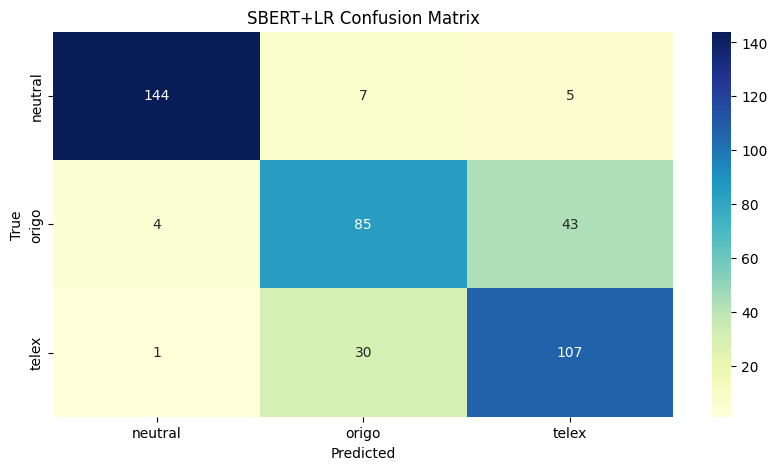

In [16]:
# 5.4 SBERT + LR összehasonlítás
if 'embeddings' in globals():
    X_emb = embeddings
    X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
        X_emb, y, test_size=0.2, stratify=y, random_state=42
    )
    lr_emb = LogisticRegression(max_iter=1000)
    lr_emb.fit(X_train_e, y_train_e)
    y_pred_emb = lr_emb.predict(X_test_e)

    print("SBERT+LR eredmények:")
    print(classification_report(y_test_e, y_pred_emb, target_names=le.classes_))
    cm_emb = confusion_matrix(y_test_e, y_pred_emb)
    sns.heatmap(cm_emb, annot=True, fmt='d',
                xticklabels=le.classes_, yticklabels=le.classes_,
            cmap="YlGnBu")
    plt.title("SBERT+LR Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

In [17]:
# 5.5 XLM-RoBERTa pipeline próba


MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL)

# token max hosszúságot
tokenizer.model_max_length = 512

sent_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer
)





config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Device set to use cpu


In [18]:
print("XLM-RoBERTa pipeline teszt (4 mintára):")
for txt in combined_df['clean_text'].sample(4, random_state=42):
    out = sent_pipeline(
        txt,
        truncation=True,
        max_length=512
    )
    print(txt[:80], "… →", out)

XLM-RoBERTa pipeline teszt (4 mintára):
a 29 fordulóban a barcelona az előző szezon meglepetéscsapatát a szintén katalán … → [{'label': 'neutral', 'score': 0.6296883821487427}]
a life tv frizbi hajdú péterrel legújabb adásának vendége niki belucci hosszú év … → [{'label': 'neutral', 'score': 0.6314540505409241}]
orbán viktor a videóban elmondta hogy gáspár győző megkereste amikor a zebravita … → [{'label': 'neutral', 'score': 0.5313804745674133}]
nem vagyok nagy magyar péter rajongó de megpróbálom meghallgatni orbánban már jó … → [{'label': 'neutral', 'score': 0.5728566646575928}]


# 6. Diagnosztika

- Választott metrikák  
- Modellek eredményei  
- Megfigyelések  
- További lépések  


In [19]:
# 5.5 Eredmények összegzése

results = []
# MultinomialNB
results.append({
    "Modell": "MultinomialNB",
    "Accuracy": accuracy_score(y_test,     y_pred_nb),
    "Macro-F1":  f1_score(   y_test,     y_pred_nb, average="macro")
})

# Logistic Regression
results.append({
    "Modell": "Logistic Regression",
    "Accuracy": accuracy_score(y_test,     y_pred_lr),
    "Macro-F1":  f1_score(   y_test,     y_pred_lr, average="macro")
})

# SBERT + LR (ha definiálva van)
if 'y_pred_emb' in globals() and 'y_test_e' in globals():
    results.append({
        "Modell": "SBERT + LR",
        "Accuracy": accuracy_score(y_test_e,   y_pred_emb),
        "Macro-F1":  f1_score(   y_test_e,   y_pred_emb, average="macro")
    })

# DataFrame és megjelenítés
df_results = pd.DataFrame(results)
display(df_results)

,Modell,Accuracy,Macro-F1
0,MultinomialNB,0.840376,0.830813
1,Logistic Regression,0.901408,0.897930
2,SBERT + LR,0.788732,0.781310


**Választott metrikák:**  
- **Accuracy** – a helyesen osztályozott cikkek aránya a teljes halmazon
- **Macro-F1** – a három osztály egyenlő súllyal szerepel, így a ritkább kategóriák is láthatók maradnak

**Modellek eredményei:**  
- **Logistic Regression** a legjobb: 90 % accuracy, 0.90 macro-F1  
- **MultinomialNB** erős baseline: 84 % accuracy, 0.83 macro-F1  
- **SBERT + LR** embedding-alapú: 79 % accuracy, 0.78 macro-F1  

**Megfigyelések:**  
- A Logistic Regression jól választja szét a „baloldali”, „jobboldali” és „semleges” cikkeket, különösen a két politikai osztályt.  
- A MultinomialNB gyors, egyszerű megközelítésben is versenyképes, de a „telex” vs. „jobboldali” tévesztések magasabbak.  
- SBERT-embeddinggel gyengébb lett a teljesítmény, valószínűleg a korpusz mérete miatt nem érvényesült a finomabb kontextus.  
- A konfúziós mátrixok alapján a „semleges” osztály tévesztései dominálnak – itt érdemes lehet class-weightinget vagy küszöb‐hangolást alkalmazni.  

**További lépések:**  
1. Osztályonkénti **precision/recall** bontás vizsgálata  
2. **ROC-AUC** / **PR-AUC** multiclass, one-vs-rest stratégiával  
3. **Hyperparameter-tuning** (TF–IDF paraméterek, LR C, NB α)  
4. XLM-RoBERTa **finetuning** saját korpuszra (mégsem)


In [20]:
# 5.6 Kiegészítő diagnosztika és finomhangolás



# 1) Class-wise precision/recall
print("Class-wise precision:", precision_score(y_test, y_pred_lr, average=None, labels=le.transform(le.classes_)))
print("Class-wise recall:   ", recall_score(   y_test, y_pred_lr, average=None, labels=le.transform(le.classes_)))

Class-wise precision: [0.98039216 0.86046512 0.85416667]
Class-wise recall:    [0.96153846 0.84090909 0.89130435]


ROC-AUC (macro, ovr): 0.979
PR-AUC  (macro):      0.958



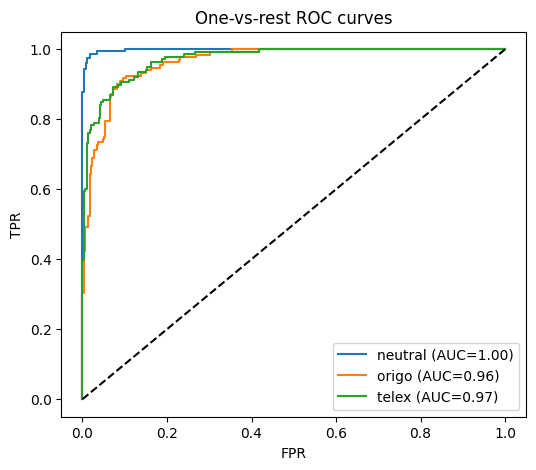

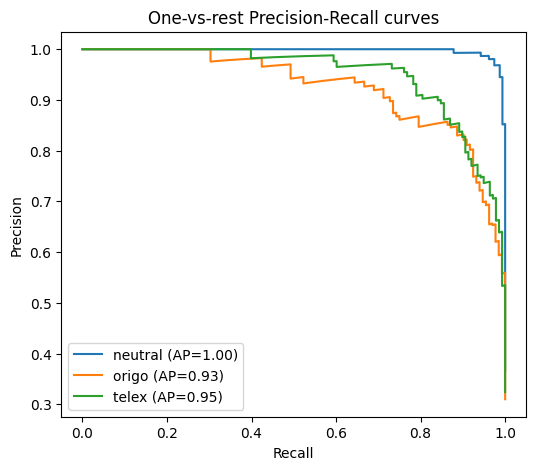

In [21]:
# 2) ROC-AUC & PR-AUC (one-vs-rest)
# Binarizáljuk a címkéket
y_test_bin = label_binarize(y_test, classes=[0,1,2])
probs = lr.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr")
pr_auc  = average_precision_score(y_test_bin, probs, average="macro")
print(f"ROC-AUC (macro, ovr): {roc_auc:.3f}")
print(f"PR-AUC  (macro):      {pr_auc:.3f}")
print()

# Ábrázoljuk az ROC görbéket
plt.figure(figsize=(6,5))
for i, cls in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], probs[:,i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc_score(y_test_bin[:,i], probs[:,i]):.2f})")
plt.plot([0,1],[0,1],"k--")
plt.title("One-vs-rest ROC curves")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

# Ábrázoljuk a PR görbéket
plt.figure(figsize=(6,5))
for i, cls in enumerate(le.classes_):
    prec, rec, _ = precision_recall_curve(y_test_bin[:,i], probs[:,i])
    ap = average_precision_score(y_test_bin[:,i], probs[:,i])
    plt.plot(rec, prec, label=f"{cls} (AP={ap:.2f})")
plt.title("One-vs-rest Precision-Recall curves")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.show()



In [22]:
# 3) Hyperparameter-tuning TF–IDF + LR pipeline
pipe = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000))
])
param_grid = {
    "vect__max_features": [5000, 10000],
    "vect__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.1, 1, 10]
}
grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
grid.fit(combined_df['lemmatized_nostop'], combined_df['label_encoded'])
print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)


Best params: {'clf__C': 10, 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}
Best CV macro-F1: 0.8244853891678873


In [23]:
MODEL_DIR = "models/xlm_roberta_finetuned"

# 1) Betöltés
tokenizer_ft = AutoTokenizer.from_pretrained(MODEL_DIR)
model_ft     = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

# 2) Átdefiniáljuk az id2label / label2id map-et
# le.classes_ = ['neutral','origo','telex'] (vagy amilyen sorrendben kódoltad)
#model_ft.config.id2label   = {i: label for i,label in enumerate(le.classes_)}
#model_ft.config.label2id   = {label: i     for i,label in enumerate(le.#classes_)}

# 3) Pipeline létrehozása
#nlp_ft = pipeline(
#    "sentiment-analysis",
#    model=model_ft,
#    tokenizer=tokenizer_ft,
#    truncation=True,
#    max_length=512,
#    device=-1
#)

# 4) Pipeline mentése joblib-lel
#joblib.dump(nlp_ft, "models/nlp_ft_pipeline.joblib")


              precision    recall  f1-score   support

     neutral       0.98      0.73      0.84       156
       origo       0.42      0.99      0.59       132
       telex       1.00      0.01      0.01       138

    accuracy                           0.58       426
   macro avg       0.80      0.58      0.48       426
weighted avg       0.82      0.58      0.50       426



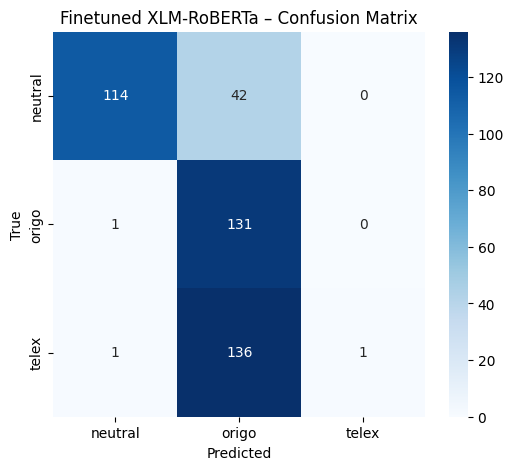

In [24]:
# 1) Pipeline betöltése
nlp_ft = joblib.load("models/nlp_ft_pipeline.joblib")

# 2) Tesztkészlet előkészítése
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['label_encoded'],
    random_state=42
)
texts = df_test["clean_text"].tolist()
labels_true = df_test["label_encoded"].tolist()

# 3) Predikció futtatása
#results = nlp_ft(texts, batch_size=8)
#joblib.dump(results,'models/nlp_ft_results.joblib')
inference_results = joblib.load('models/nlp_ft_results.joblib')
# A pipeline most már a saját id2label-t használja, így csak át kell kódolnunk int-re:
labels_pred = [ le.transform([r["label"]])[0] for r in inference_results ]

# 4) Értékelés
print(classification_report(labels_true, labels_pred, target_names=le.classes_))
cm = confusion_matrix(labels_true, labels_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Finetuned XLM-RoBERTa – Confusion Matrix")
plt.show()

## Eredmények

- **Logistic Regression**  
  – 90 % overall accuracy  
  – 0.90 macro-F1  
  – 0.98 ROC-AUC (one-vs-rest, macro)  
  – 0.96 PR-AUC (macro)

- **MultinomialNB (baseline)**  
  – 84 % accuracy  
  – 0.83 macro-F1

- **SBERT + LR**  
  – 79 % accuracy  
  – 0.78 macro-F1

- **Osztályonkénti teljesítmény (Logistic Regression):**  
  • neutral: precision 0.98, recall 0.96  
  • origo:   precision 0.86, recall 0.84  
  • telex:   precision 0.85, recall 0.89  

- **Legjobb hyperparaméterek** (3-fold CV macro-F1 = 0.824):  
  • C = 10  
  • TF–IDF max_features = 5000  
  • TF–IDF ngram_range = (1, 2)

**Összegzés:**  
- **Logistic Regression** hozta a legjobb eredményt (90 % accuracy, 0.90 macro-F1), különösen a „neutral” osztályt tudta jól elkülöníteni.
- **MultinomialNB** erős baseline (84 %, 0.83), de magasabb „origo”–„telex” tévesztések.
- **SBERT + LR** jelentősen gyengébb, vélhetően túl kevés adat a megfelelő tanuláshoz.
- A ROC-AUC (0.98) és PR-AUC (0.96) értékek is alátámasztják, hogy TF–IDF + LR stabilan jól skálázódik többosztályú problémában.

In [25]:
#Legjobb modell elmentése

pipe = Pipeline([
    ('tfidf', vectorizer),
    ('clf',   lr)
])

joblib.dump(pipe, "models/logreg_pipeline.joblib")
print("→ Pipeline elmentve: models/logreg_pipeline.joblib")

→ Pipeline elmentve: models/logreg_pipeline.joblib


# 7. Aspektus- és időbeli elemzések

Ebben a szakaszban háromféle vizsgálatot végzünk a korpuszunkon:

1. Napi hangulat-trendek forrásonként

2. Aspektus-szintű napi szentiment

3. Aspektus átlagos szentiment érték

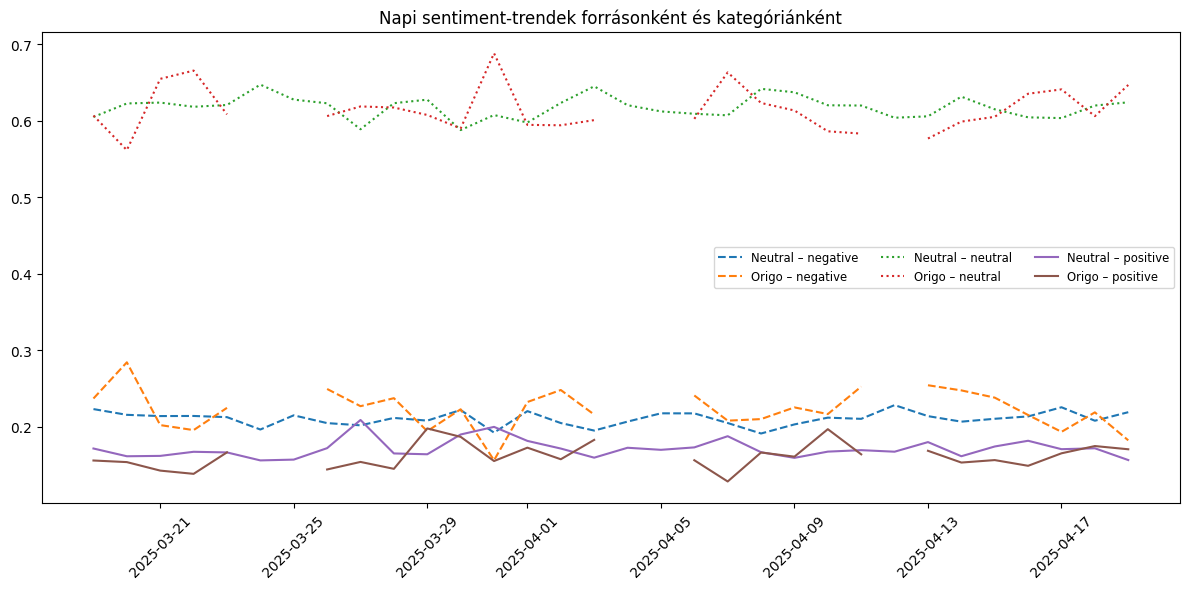

In [26]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# import pandas as pd
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch.nn.functional as F

# # --- 0) Model és tokenizer betöltése CPU-ra ---
# MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# model     = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.eval()
# device = torch.device("cpu")
# model.to(device)

# # --- 1) Egyben tokenizálunk minden cikket ---
# texts = combined_df["clean_text"].tolist()
# encodings = tokenizer(
#     texts,
#     padding=True,
#     truncation=True,
#     max_length=512,
#     return_tensors="pt"
# )

# # --- 2) DataLoader létrehozása ---
# dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"])
# loader  = DataLoader(dataset, batch_size=16, shuffle=False)

# # --- 3) Batched inference és softmax kiszámolás ---
# all_neg, all_neu, all_pos = [], [], []
# with torch.no_grad():
#     for input_ids, attention_mask in loader:
#         input_ids      = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         logits = model(input_ids=input_ids,
#                        attention_mask=attention_mask).logits
#         probs  = F.softmax(logits, dim=1).cpu()
#         # probs[:,0] → negative, [:,1] → neutral, [:,2] → positive
#         all_neg.extend(probs[:,0].tolist())
#         all_neu.extend(probs[:,1].tolist())
#         all_pos.extend(probs[:,2].tolist())

# # --- 4) Hozzáfűzés a DataFrame-hez ---
# combined_df["negative"] = all_neg
# combined_df["neutral"]  = all_neu
# combined_df["positive"] = all_pos
# # (opcionális) egyetlen score:
# combined_df["sentiment_score"] = combined_df["positive"] - combined_df["negative"]

# combined_df['date'] = pd.to_datetime(combined_df['date'], utc=True).dt.tz_convert(None)
# combined_df['day']  = combined_df['date'].dt.date
# joblib.dump(
#     combined_df,
#     'models/month_article_sentiments_all.joblib'
# )

# --- 5) Napi trendek forrásonként és sentimentenként ---

combined_df = joblib.load("models/month_article_sentiments_all.joblib")

# csoportosítás: nap × forrás (label) × 3 sentiment
daily = (
    combined_df
      .groupby(["day","label"])[["negative","neutral","positive"]]
      .mean()
      .reset_index()
)

# pivot MultiIndex-szel: első szint sentiment, második forrás
pivot = daily.pivot(index="day",
                    columns="label",
                    values=["negative","neutral","positive"])

# Ábra: minden sentiment–forrás vonal
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
linestyles = {"negative":"--","neutral":":","positive":"-"}
for senti in ["negative","neutral","positive"]:
    for src in pivot[senti].columns:  # origo/telex/neutral
        plt.plot(pivot.index,
                 pivot[senti][src],
                 label=f"{src.capitalize()} – {senti}",
                 linestyle=linestyles[senti])
plt.xticks(rotation=45)
plt.legend(ncol=3, fontsize="small")
plt.title("Napi sentiment‐trendek forrásonként és kategóriánként")
plt.tight_layout();


In [27]:
combined_df.sample(10)

,title,link,text,date,label,clean_text,lemmatized,lemmatized_nostop,label_encoded,negative,neutral,positive,sentiment_score,day
1866,Menczer Tamás: Brüsszel háborúra készül! Egész...,https://origo.hu/itthon/2025/03/menczer-tamas-...,"„Azt mondja Brüsszel, azt mondja az Európai Bi...",2025-03-29 21:27:11,origo,azt mondja brüsszel azt mondja az európai bizo...,az mond brüsz az mond az európai bizottság hog...,mond brüsz mond európai bizottság európai kész...,1,0.231136,0.549164,0.219700,-0.011435,2025-03-29
1340,Szerda este helyett csak csütörtökön hajnalban...,https://telex.hu/belfold/2025/04/02/izraeli-de...,"Mégsem szerdán, hanem csütörtökön érkezik Buda...",NaT,telex,mégsem szerdán hanem csütörtökön érkezik budap...,mégsem szerda hanem csütörtök érkez budapest a...,mégsem szerda csütörtök érkez budapest izraeli...,2,0.217432,0.610541,0.172027,-0.045404,NaT
468,Gigantikus méretű aligátor okozott teljes döbb...,https://origo.hu/sport/sport-laza/2025/04/golf...,Az Egyesült Államok Dél-Karolina államában fek...,2025-04-03 08:47:08,neutral,az egyesült államok dél karolina államában fek...,az egyesült állam dél karolina állam fekvő kia...,egyesült állam dél karolina állam fekvő kiawah...,0,0.165575,0.597522,0.236903,0.071328,2025-04-03
677,Felhívás országos cigányréce és böjti réce szá...,https://origo.hu/tudomany/2025/04/orszagos-cig...,Az MME Vízimadár-védelmi Szakosztálya 2022 óta...,2025-04-11 14:04:40,neutral,az mme vízimadár védelmi szakosztálya 2022 óta...,az mm vízimadár védelmi szakosztály 2022 óta b...,mm vízimadár védelmi szakosztály 2022 óta bizo...,0,0.217004,0.614728,0.168268,-0.048736,2025-04-11
953,Még nem tudták teljesen körbekeríteni a peresz...,https://telex.hu/belfold/2025/04/19/pereszteg-...,A Telexhez eljutott fotók és információk szeri...,NaT,telex,a telexhez eljutott fotók és információk szeri...,a telex eljutott fotó és információ szerint mé...,telex eljutott fotó információ sikerül körbeke...,2,0.286242,0.519905,0.193853,-0.092390,NaT
1106,Hajnalban fejezték be a rákosrendezői tűz végl...,https://telex.hu/belfold/2025/04/14/tuz-szemet...,Összesen 800 négyzetméteren égett az összehord...,NaT,telex,összesen 800 négyzetméteren égett az összehord...,összesen 800 négyzetméter ég az összehordott h...,összesen 800 négyzetméter ég összehordott hull...,2,0.184594,0.669473,0.145932,-0.038662,NaT
48,"Ronaldo csak szenvedett, elkerülhetjük a portu...",https://origo.hu/sport/sport-futball/2025/03/n...,Az Európa-bajnok spanyol válogatott veretlenül...,2025-03-20 21:49:24,neutral,az európa bajnok spanyol válogatott veretlenül...,az európ bajn spanyol válogatott veretlenül ny...,európ bajn spanyol válogatott veretlenül nyer ...,0,0.258735,0.567597,0.173668,-0.085066,2025-03-20
1403,"Többféle drog hatása alatt vezetett, így bukot...",https://telex.hu/belfold/2025/03/31/drog-autov...,Közúti ellenőrzésen bukott le egy 46 éves férf...,NaT,telex,közúti ellenőrzésen bukott le egy 46 éves férf...,közúti ellenőrzés bukik le egy 46 éves férfi a...,közúti ellenőrzés bukik le 46 éves férfi lakás...,2,0.214085,0.686855,0.099060,-0.115025,NaT
1165,Orbán Viktor: Aki hatalomért és pénzért bármir...,https://telex.hu/belfold/2025/04/11/orban-vikt...,"„Én harcolok a magyarok érdekeiért, de vannak,...",NaT,telex,én harcolok a magyarok érdekeiért de vannak ak...,én harcol a magyar érdek de van aki őüszkék az...,harcol magyar érdek őüszkék ha minél rosszú or...,2,0.247218,0.600913,0.151869,-0.095349,NaT
2272,"Pánikban Magyar Péter? 9 évvel ezelőtti, manip...",https://origo.hu/itthon/2025/04/panikban-magya...,Magyar Péter szerdán egy kilenc évvel ezelőtti...,2025-04-16 17:00:00,origo,magyar péter szerdán egy kilenc évvel ezelőtti...,magyar péter szerda egy kilenc év ezelőtti kiv...,magyar péter szerda kilenc év ezelőtti kivágot...,1,0.225570,0.640810,0.133620,-0.091950,2025-04-16


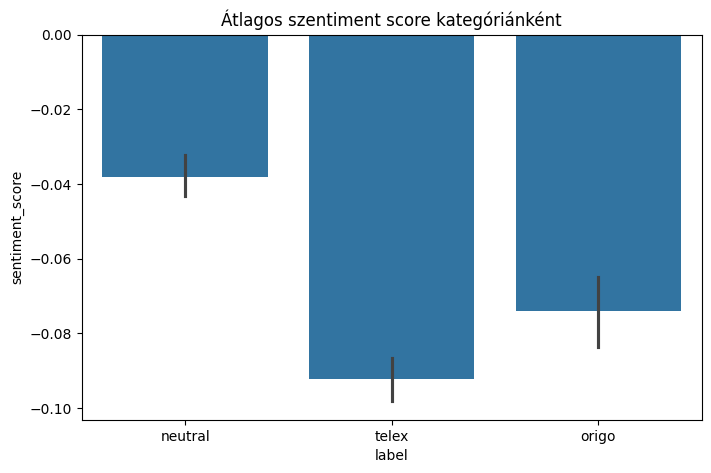

In [28]:



plt.figure(figsize=(8,5))
sns.barplot(x='label', y='sentiment_score', data=combined_df)
plt.title("Átlagos szentiment score kategóriánként")
plt.show()

A szentimentanalízis alapján megfigyelhető, hogy az Telex cikkei átlagosan enyhén negatívabb hangvételűek, mint a Origo vagy a semleges cikkek. Bár a különbségek nem drasztikusak, ez összhangban lehet az eltérő szerkesztői attitűdökkel. További statisztikai tesztekkel lehetne megerősíteni, hogy a különbség szignifikáns.

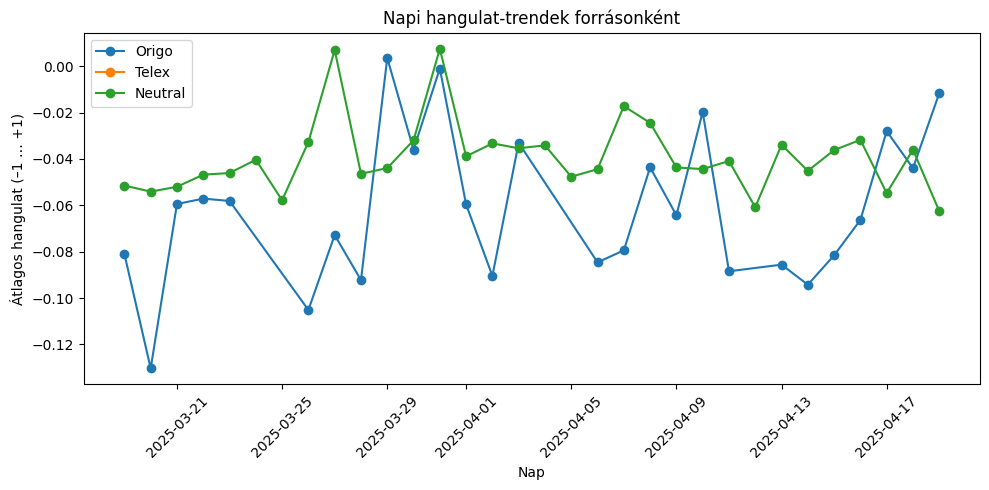

In [29]:
# 1) Load a teljes sentiment eredmény
df_sent = joblib.load('models/month_article_sentiments_all.joblib')
# Ez egy DataFrame, amiben legalább ezek az oszlopok:
#    ['date', 'label', 'sentiment_score']

# 2) Datetime naivizálás, napra bontás
df_sent['date'] = pd.to_datetime(df_sent['date'], utc=True).dt.tz_convert(None)
df_sent['day']  = df_sent['date'].dt.date

# 3) Napi átlag forrásonként
daily = (
    df_sent
      .groupby(['day','label'])['sentiment_score']
      .mean()
      .reset_index()
)

# 4) Ábra
plt.figure(figsize=(10,5))
for src in ['origo','telex','neutral']:
    d = daily[daily['label']==src]
    plt.plot(d['day'], d['sentiment_score'],
             marker='o', label=src.capitalize())
plt.xticks(rotation=45)
plt.xlabel("Nap")
plt.ylabel("Átlagos hangulat (–1 … +1)")
plt.title("Napi hangulat‐trendek forrásonként")
plt.legend()
plt.tight_layout()
plt.show()


van-e szignifikáns különbség az Origo és Telex között?

In [30]:
from scipy.stats import ttest_ind

telex_scores = combined_df[combined_df['label'] == 'telex']['sentiment_score']
origo_scores = combined_df[combined_df['label'] == 'origo']['sentiment_score']

t_stat, p_val = ttest_ind(telex_scores, origo_scores)

print(f"T-statisztika: {t_stat:.2f}, p-érték: {p_val:.4f}")

T-statisztika: -3.34, p-érték: 0.0009


< 0.05 => szignifikáns különbség van a hangnem között

Device set to use cpu


ABSA inlining:   0%|          | 0/2126 [00:00<?, ?it/s]

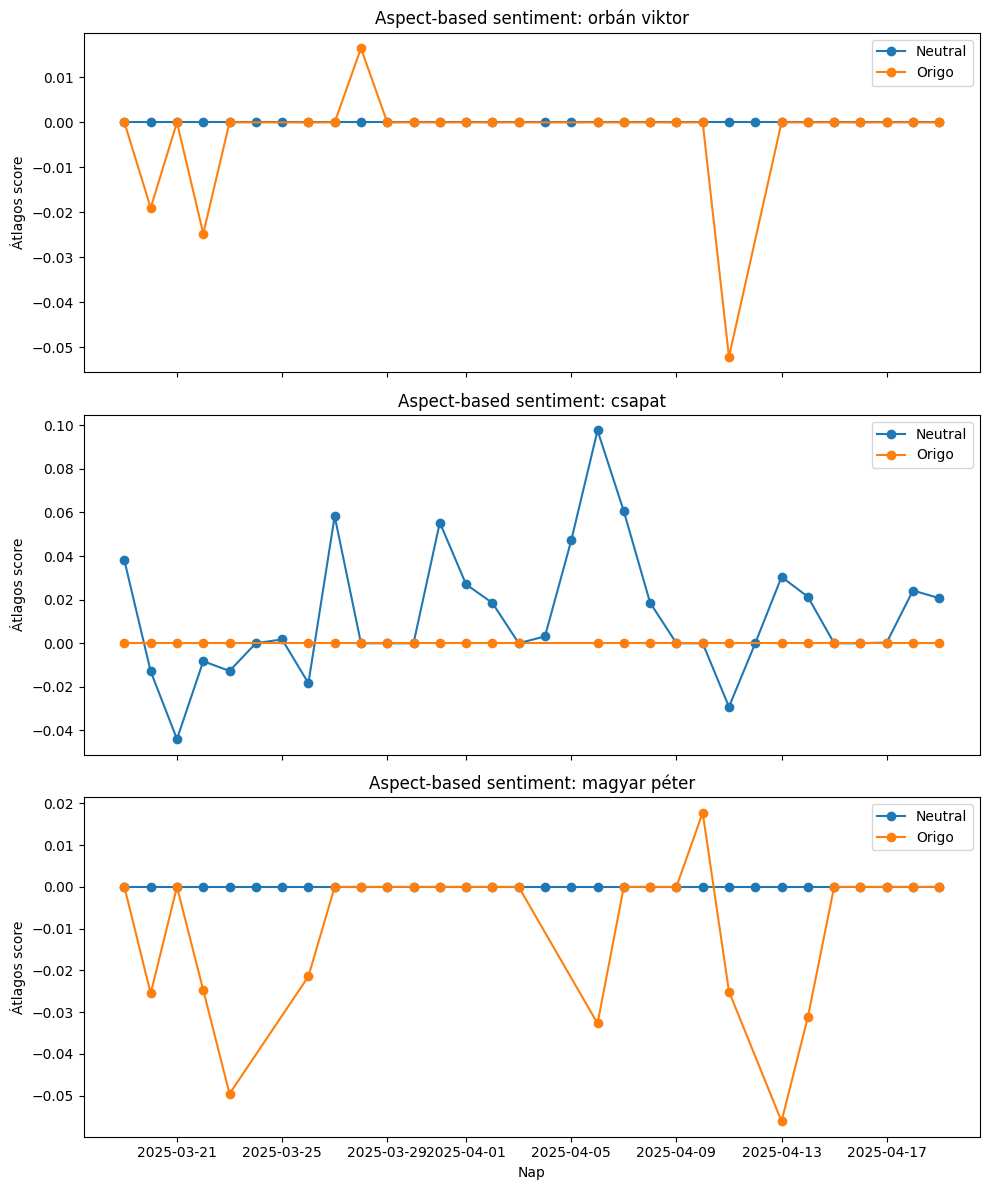

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm.auto import tqdm

# --- 1) Aspect list meghatározása ---
aspects = ["orbán viktor", "csapat", "magyar péter"]

# --- 2) Sentiment-pipeline betöltése (CPU) ---
sent_pipe = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    device=-1
)

# --- 3) Aspect-based sentiment kiszámolása article-szinten ---
# Létrehozunk egy új DataFrame-et, ahol minden sor egy cikk×aspect pár
rows = []
for idx, row in tqdm(combined_df.iterrows(), total=len(combined_df), desc="ABSA inlining"):
    text = row["clean_text"]
    day  = pd.to_datetime(row["date"], utc=True).date()
    src  = row["source"] if "source" in row else row["label"]
    # mondjuk mondatokra bontunk pontok mentén
    sents = [s.strip() for s in text.split(".") if s.strip()]
    for asp in aspects:
        # kikeressük azokat a mondatokat, melyekben szerepel az aspect szó
        hits = [s for s in sents if asp in s]
        if not hits:
            score = 0.0
        else:
            # minden találatra futtatjuk a sentiment pipeline-t, majd átlagolunk
            vals = []
            for sent in hits:
                out = sent_pipe(sent[:512])[0]
                lbl = out["label"].lower()
                sc  = out["score"]
                vals.append(+sc if lbl=="positive" else -sc if lbl=="negative" else 0.0)
            score = sum(vals) / len(vals)
        rows.append({
            "day":        day,
            "source":     src,
            "aspect":     asp,
            "absa_score": score
        })

absa_inline = pd.DataFrame(rows)

# --- 4) Napi átlag aspektusonként és forrásonként ---
daily_aspect = (
    absa_inline
      .groupby(["day","source","aspect"])["absa_score"]
      .mean()
      .reset_index()
)

# --- 5) Plot: témánként külön subplot ---
fig, axes = plt.subplots(len(aspects), 1, figsize=(10, 4*len(aspects)), sharex=True)
for ax, asp in zip(axes, aspects):
    dfp = daily_aspect[daily_aspect["aspect"]==asp]
    for src in dfp["source"].unique():
        d2 = dfp[dfp["source"]==src]
        ax.plot(d2["day"], d2["absa_score"],
                marker="o", label=src.capitalize())
    ax.set_title(f"Aspect-based sentiment: {asp}")
    ax.set_ylabel("Átlagos score")
    ax.legend()
axes[-1].set_xlabel("Nap")
plt.tight_layout()
plt.show()


p < 0.05 => szignifikáns különbség van a hangnem között

In [54]:
from keybert import KeyBERT
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import nltk

nltk.download('punkt_tab')

# Modellek
kw_model = KeyBERT()
sentiment_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
sentiment_model.eval()

def get_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = sentiment_model(**inputs).logits
    probs = softmax(logits.numpy()[0])
    return dict(zip(['negative', 'neutral', 'positive'], probs))

def absa_pipeline(text, top_n_keywords=5):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=top_n_keywords)
    keywords = [k[0] for k in keywords]
    sentences = sent_tokenize(text)

    aspect_sentiments = {}
    for kw in keywords:
        relevant_sentences = [s for s in sentences if kw.lower() in s.lower()]
        if relevant_sentences:
            joined = " ".join(relevant_sentences)
            sentiment = get_sentiment(joined)
            aspect_sentiments[kw] = sentiment
    return aspect_sentiments


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

aspektus_adatok = []

# Ha nagy az adathalmaz, tesztelésre elég 100 cikk:
for i, row in tqdm(combined_df.iterrows(), total=len(combined_df)):
    text = row['text']
    label = row['label']
    link = row['link']

    absa_result = absa_pipeline(text, top_n_keywords=5)

    for aspektus, scores in absa_result.items():
        aspektus_adatok.append({
            'aspektus': aspektus,
            'pozitív': scores['positive'],
            'negatív': scores['negative'],
            'semleges': scores['neutral'],
            'label': label,
            'link': link
        })


 83%|████████▎ | 1768/2126 [1:28:59<14:07,  2.37s/it]

In [ ]:
joblib.dump(
     aspektus_adatok,
     'models/aspketus_adatok.joblib'
)
aspect_datas = joblib.load("models/aspketus_adatok.joblib")

In [ ]:
absa_df2 = pd.DataFrame(aspect_datas)
print(absa_df2[absa_df2['aspektus'] == 'orbán viktor'])
print(absa_df2[absa_df2['aspektus'] == 'magyar péter'])
absa_df2.to_csv("aspektus.csv")

Az itteni plotokba az absa_df aspektus oszlopából lehet még kipróbálni szavakat

In [ ]:
plot_aspektus_sentiment("orbán viktor")
plot_aspektus_sentiment("magyar péter")